In [1]:
# Import libraries
import requests
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import numpy as np
import re
import unicodedata
from sklearn.decomposition import PCA


%matplotlib inline

In part 1 (top universities) we will create function to compute and plot the different required ratios that we will reuse in part 2.

# www.topuniversities.com

The ranking is broken and contains only the top 199 universities even though the last university has rank 200, if we want to have 200 universities we should include the university ranked 201, as we want the top 200, we will take only the 199 first universities.

In [9]:
r = requests.get("https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt")
json_dict = r.json()
json_dict = json_dict['data']
json_dict = json_dict[:199]

for e in json_dict:
    #Delete useless informations
    del e['nid']
    del e['logo']
    del e['core_id']
    del e['score']
    del e['cc']
    del e['stars']
    del e['guide']
    
    #Get the university specific url
    r = requests.get("https://www.topuniversities.com/" + e['url'])
    soup = BeautifulSoup(r.text, 'html.parser')
    
    #Get faculty members numbers
    scrap_list = soup.find_all('div', class_='faculty-main wrapper col-md-4')
    if(len(scrap_list) == 0): #If no informations about the faculty members is given
        e['# Faculty members'] = 0
        e['# Int. faculty members'] = 0
    else:
        n_list = scrap_list[0].find_all(class_="number")
        if(len(n_list) == 2):
            e['# Faculty members'] = int(re.sub(',', '', n_list[0].text.strip()))
            e['# Int. faculty members'] = int(re.sub(',', '', n_list[1].text.strip()))
        else: #If they don't have international faculty member
            e['# Faculty members'] = int(re.sub(',', '', n_list[0].text.strip()))
            e['# Int. faculty members'] = 0
    
    #Get students numbers
    n_list = soup.find_all('div', class_='students-main wrapper col-md-4')
    if(len(n_list) != 0):
        e['# Students'] = int(re.sub(',', '', n_list[0].find_all(class_="number")[0].text.strip()))   
    else:
        e['# Students'] = 0

    n_list = soup.find_all('div', class_='int-students-main wrapper col-md-4')
    if(len(n_list) != 0):
        e['# Int. students'] = int(re.sub(',', '', n_list[0].find_all(class_="number")[0].text.strip()))
    else:
        e['# Int. students'] = 0
    
    #We don't need the url anymore, we can delete it
    del e['url']
    
df1 = pd.DataFrame(json_dict)

df1=df1.rename(columns = {'rank_display':'Rank', 'title' : 'University', 'country' : 'Country', 'region' : 'Region'})
df1.index = df1['University']
del df1['University']

## Per university ratio

### Ratio between faculty members and students

Best university according to ratio between faculty members and students. We assume that a bigger ratio is better. Even though it might not be desirable, we assume it is the case for this exercise.
We plot the bar charts only for the first 30 universites (according to the ratio) to get an idea of the trend.

In [10]:
def uni_ratio_fac_stu(df):
    #Compute ratio
    df['Ratio Faculty members'] = df['# Faculty members']/df['# Students']

    #Sort the rows according to ratio and locate the top 30 ones
    df_sorted_ratios = df.sort_values(by=['Ratio Faculty members'], ascending=False).head(30)

    #Plot the bar chart and print the best one
    fig, ax = plt.subplots(figsize=(20,10))

    plot = sns.barplot(y=df_sorted_ratios['Ratio Faculty members'], x=df_sorted_ratios.index, ax=ax)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    print("Best university according to ratio between faculty members and students is : " + df_sorted_ratios.iloc[0].name)

    #Delete the ratio column of the dataframe
    del df_sorted_ratios

Best university according to ratio between faculty members and students is : California Institute of Technology (Caltech)


/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


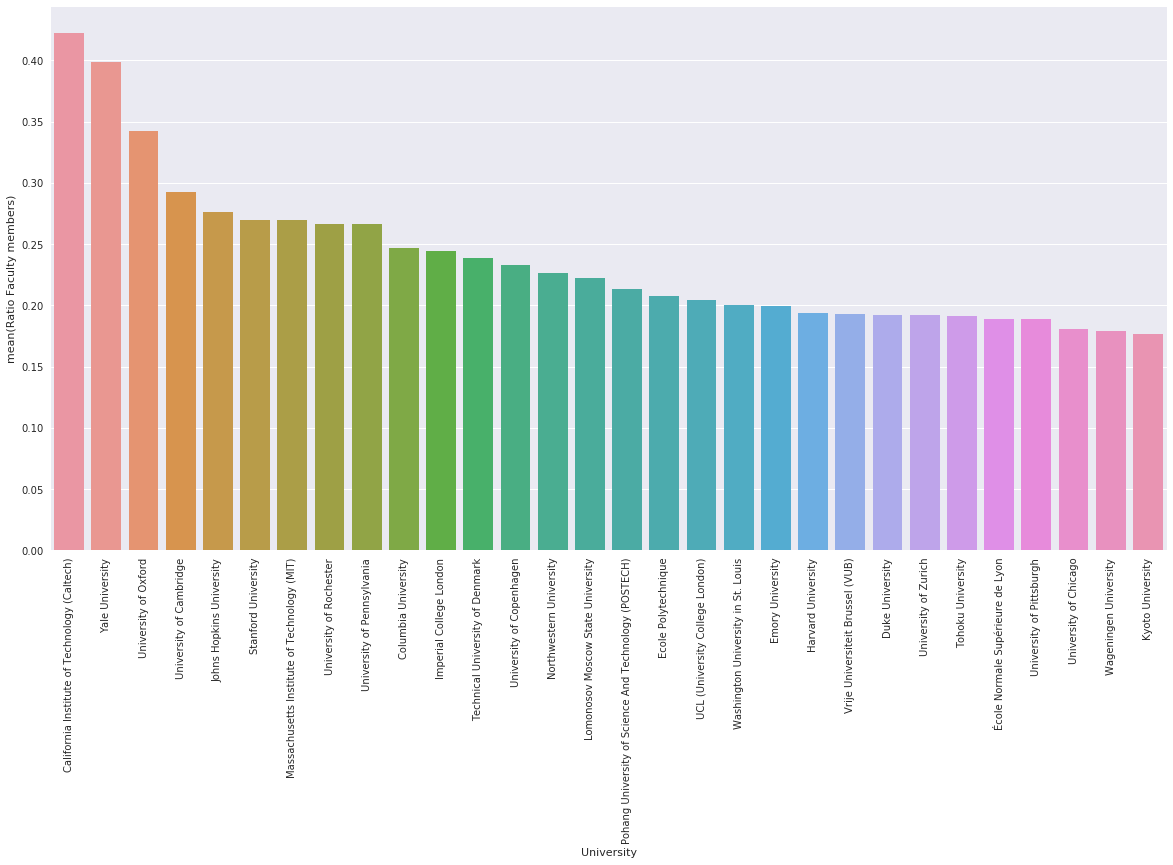

In [11]:
uni_ratio_fac_stu(df1)

As we can see except for the first few universites which clearly have a higher ratio than the others, the ratio tends to decrease in a linear fashion

Best university according to ratio between local and international students. We assume that a ratio of 1 is the best, that is the same number of local and international students.
Again we only plot the first 30 ones.

In [12]:
def uni_ratio_int_stu(df):
    #Compute ratio
    df['Ratio Int. students'] = df['# Int. students']/df['# Students']

    #Sort the rows according to ratio and locate the top 30 ones
    df_sorted_ratios = df.sort_values(by=['Ratio Int. students'], ascending=False).head(30)

    #Plot the bar chart and print the best one
    fig, ax = plt.subplots(figsize=(20,10))

    plot = sns.barplot(y=df_sorted_ratios['Ratio Int. students'], x=df_sorted_ratios.index, ax=ax)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

    print("Best university according to ratio between local and international students is : " + df_sorted_ratios.iloc[0].name)

    #Delete the ratio column of the dataframe
    del df_sorted_ratios

Best university according to ratio between local and international students is : London School of Economics and Political Science (LSE)


/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


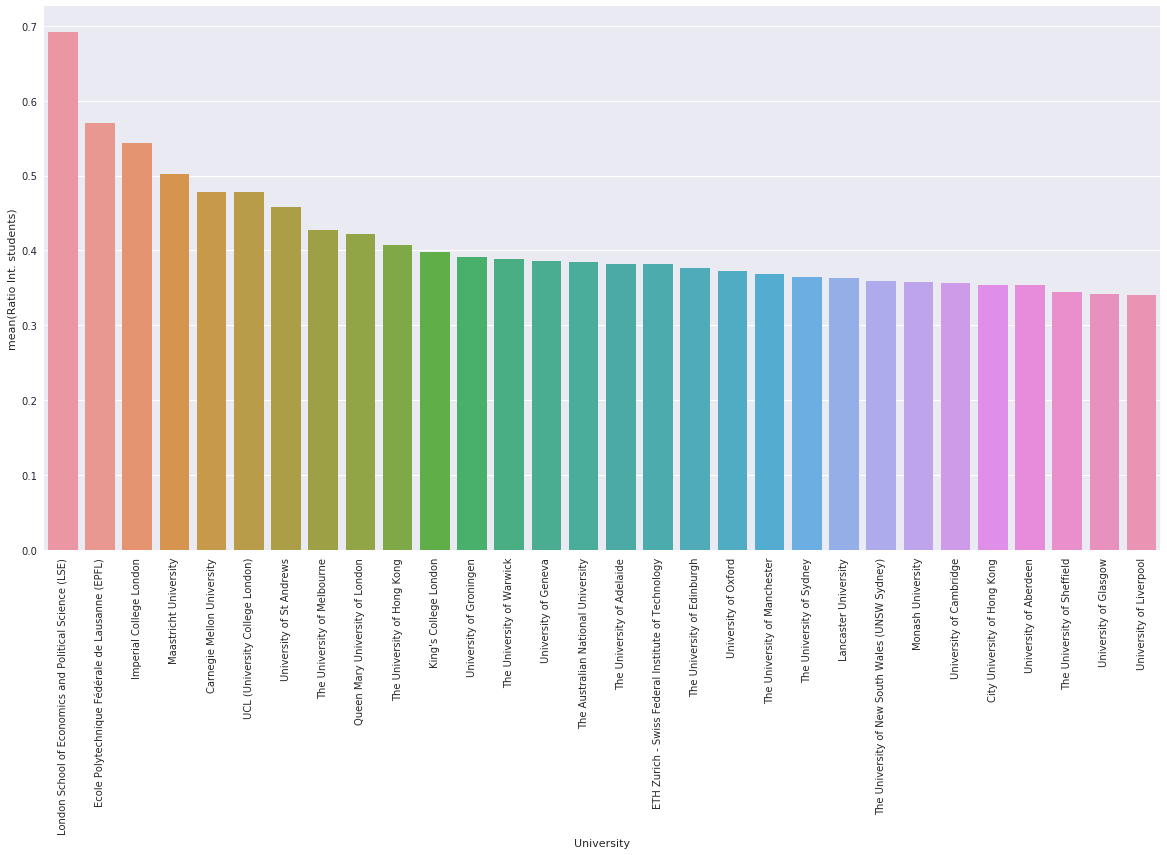

In [13]:
uni_ratio_int_stu(df1)

Same observations as for the previous bar charts. It is good to note that the universities and their order are not the same as the previous ones.

## Per country ratio

### Ratio between faculty members and students

Let's find the best country according to the ratio between faculty members and students. Previous assumptions about what is the best ratio still hold.

In [14]:
def country_ratio_fac_stu(df):
    #Group by country and compute the ratios
    df['Ratio'] = df['# Faculty members']/df['# Students']

    #Sort the rows according to ratios
    sorted_df = df.sort_values(by=['Ratio'], ascending=False)

    #Plot the bar chart and print the best one
    fig, ax = plt.subplots(figsize=(20,10))

    plot = sns.barplot(y=sorted_df.Ratio, x=sorted_df.index, ax=ax)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=50)
    print("Best country according to ratio between faculty members and students is : " + sorted_df.iloc[0].name)

    #Delete datas we don't need anymore
    del df['Ratio']
    del sorted_df

In [15]:
df1_country = df1.groupby(['Country']).agg(sum)

Best country according to ratio between faculty members and students is : Russia


/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


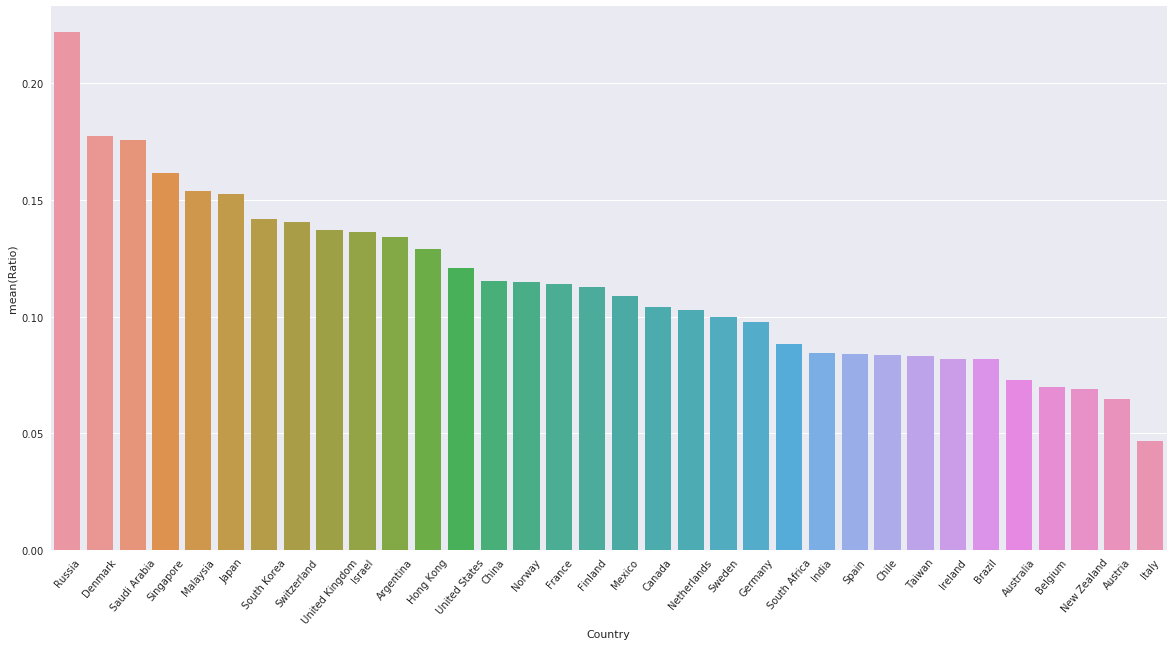

In [16]:
country_ratio_fac_stu(df1_country)

Russia is the exception with a high number in comparison of the others. Again the rest decreases in a linear fashion.

### Ratio between local and international students

Let's find the best country according to the ratio between local and international students. Previous assumptions about what is the best ratio still hold.

In [17]:
def country_ratio_int_stu(df):
    #Compute the ratios
    df['Ratio'] = df['# Int. students']/df['# Students']

    #Sort the rows according to ratios
    sorted_df = df.sort_values(by=['Ratio'], ascending=False)

    #Plot the bar chart and print the best one
    fig, ax = plt.subplots(figsize=(20,10))

    plot = sns.barplot(y=sorted_df.Ratio, x=sorted_df.index, ax=ax)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=50)
    print("Best country according to ratio between local and international students is : " + sorted_df.iloc[0].name)

    #Delete datas we don't need anymore
    del df
    del sorted_df

Best country according to ratio between local and international students is : Australia


/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


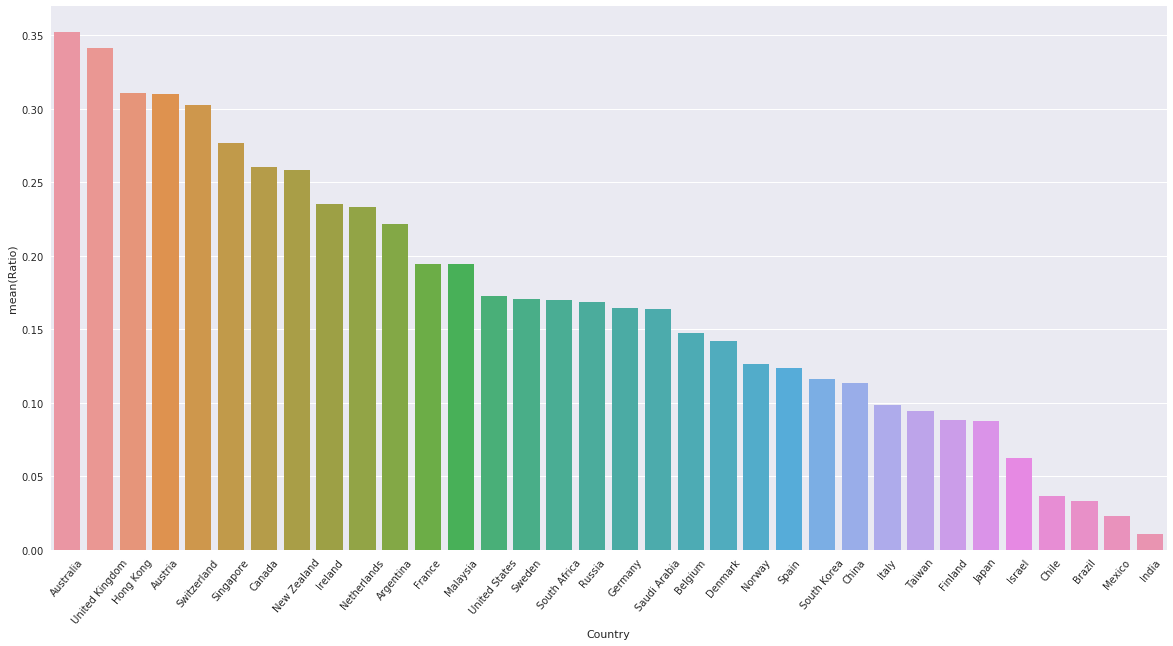

In [18]:
country_ratio_int_stu(df1_country)

This bar chart is a bit different than the previous ones. Indeed the first ratios decrease way faster than the last ones but we could still use two linear functions to approximate the decrease.

## Per region ratio

### Ratio between faculty members and students

Let's find the best region according to the ratio between faculty members and students. Previous assumptions about what is the best ratio still hold.

In [19]:
def region_ratio_fac_stu(df):
    #Group by region and compute the ratios
    df['Ratio'] = df['# Faculty members']/df['# Students']

    #Sort the rows according to ratios
    sorted_df = df.sort_values(by=['Ratio'], ascending=False)

    #Plot the bar chart and print the best one
    fig, ax = plt.subplots(figsize=(20,10))

    df = df.groupby(['Region']).agg(sum)
    plot = sns.barplot(y=sorted_df.Ratio, x=sorted_df.index, ax=ax)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=50)

    print("Best region according to ratio between faculty members and students is : " + sorted_df.iloc[0].name)

    #Delete datas we don't need anymore
    del df['Ratio']

In [20]:
df1_region = df1.groupby(['Region']).agg(sum)

Best region according to ratio between faculty members and students is : Asia


/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


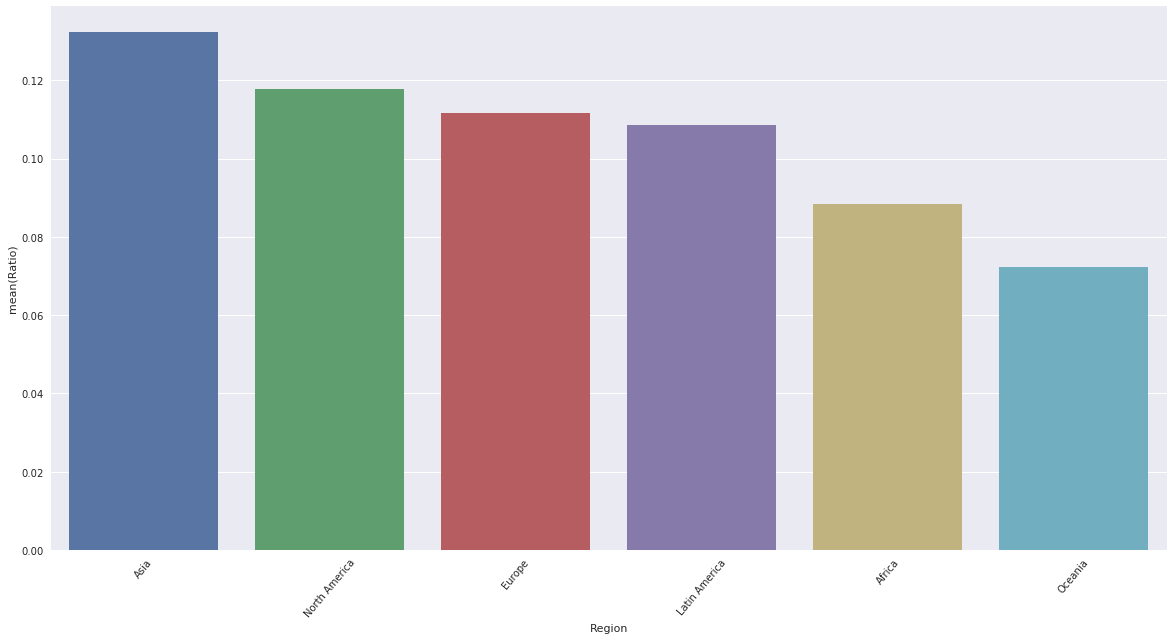

In [21]:
region_ratio_fac_stu(df1_region)

### Ratio between local and international students

Let's find the best region according to the ratio between local and international students. Previous assumptions about what is the best ratio still hold.

In [22]:
def region_ratio_int_stu(df):
    #Compute the ratios
    df['Ratio'] = df['# Int. students']/df['# Students']

    #Sort the rows according to ratios
    sorted_df = df.sort_values(by=['Ratio'], ascending=False)

    #Plot the bar chart and print the best one
    fig, ax = plt.subplots(figsize=(20,10))

    plot = sns.barplot(y=sorted_df.Ratio, x=sorted_df.index, ax=ax)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=50)

    print("Best region according to ratio between local and international students is : " + sorted_df.iloc[0].name)

    #Delete datas we don't need anymore
    del df
    del sorted_df

Best region according to ratio between local and international students is : Oceania


/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


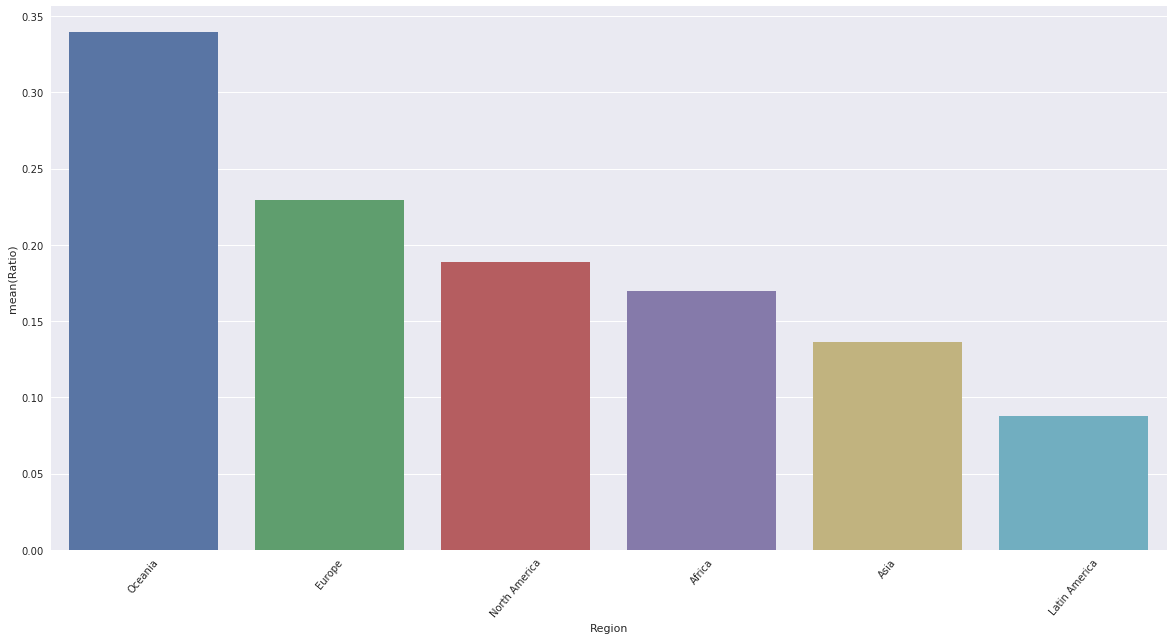

In [23]:
region_ratio_int_stu(df1_region)

Oceania is clearly the leader here.

 # www.timeshighereducation.com

Helper to get the region way more easily

In [24]:
countries = dict(df1[['Country', 'Region']].drop_duplicates().values.tolist())
countries['Luxembourg'] = 'Europe'

URL containing the requested data in json 

In [25]:
timeshighereducation_url = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"

ranking_brute = requests.get(timeshighereducation_url).json()['data']

In [26]:
infos_to_keep = ["rank", "name", "location", "stats_number_students", "stats_pc_intl_students", "stats_student_staff_ratio"]
column_names =  ["Rank", "University", "Country", "# Students", "% Int. students", "% Faculty members"]

In [27]:
# creating dataframe
df2 = pd.DataFrame(ranking_brute[:200], index=range(1, 201), columns=infos_to_keep)

# more expressive column names
df2.columns = column_names

df2["Rank"] = df2["Rank"].apply(lambda x: int(re.sub("[^0-9]", "", x)))

# string to numerical values
df2["# Students"] = pd.to_numeric(df2["# Students"].map(lambda x: x.replace(",", "")))
df2["% Int. students"] = pd.to_numeric(df2["% Int. students"].map(lambda x: x.replace("%", ".")))
df2["% Faculty members"] = pd.to_numeric(df2["% Faculty members"])

# adding number of international students
df2["# Int. students"] = (df2["# Students"] * df2["% Int. students"] / 100).map(round)

# adding number of faculty members
df2["# Faculty members"] = (df2["# Students"] / df2["% Faculty members"]).map(round)

# Changing Russian federation to Russia
df2['Country'].replace('Russian Federation', 'Russia', inplace=True)

# adding regions
df2["Region"] = df2["Country"].map(lambda c: countries[c])

# Usign meaningful index
df2.index = df2['University']
del df2['University']

# Deleting % Int. students because it is not needed anymore
del df2['% Int. students']
del df2["% Faculty members"]

## Per university ratio

### Ratio between faculty members and students

Best university according to ratio between faculty members and students. We assume that a bigger ratio is better. Even though it might not be desirable, we assume it is the case for this exercise.
Again we plots only the first 30 ones.

Best university according to ratio between faculty members and students is : Vanderbilt University


/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


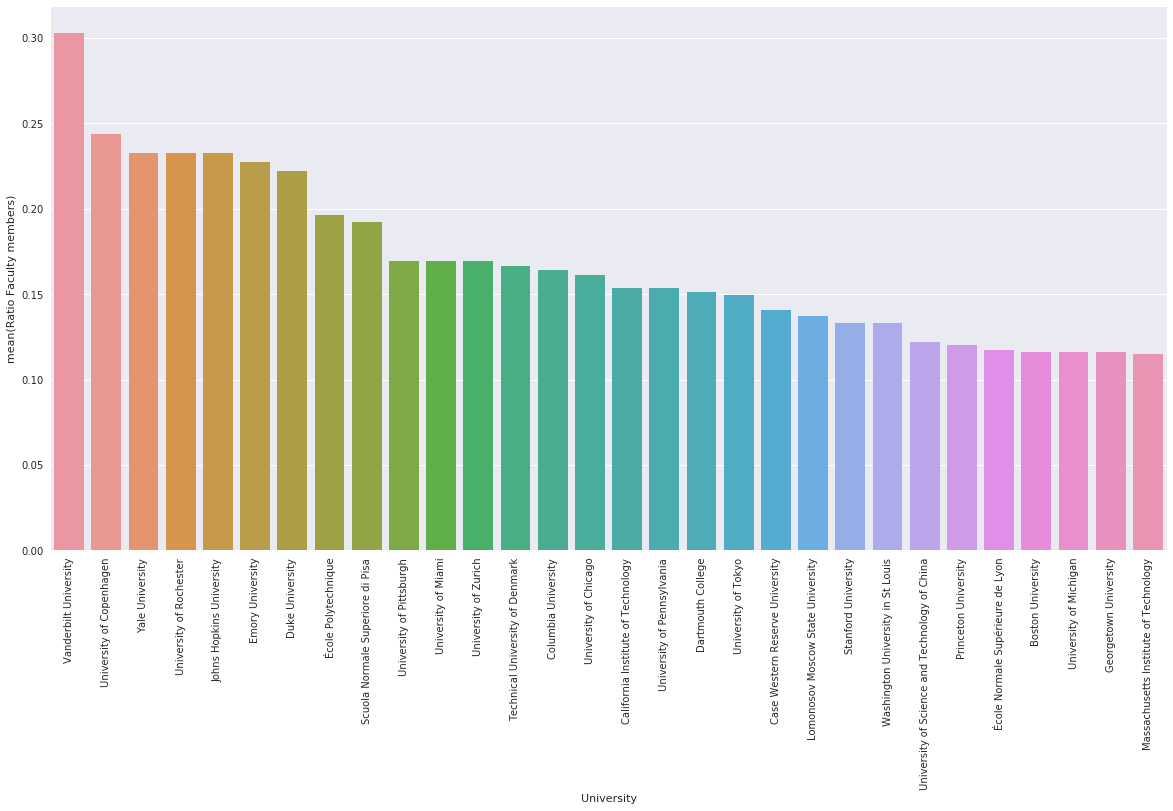

In [28]:
uni_ratio_fac_stu(df2)

### Ratio between local and international students

Best university according to ratio between local and international students. We assume that a ratio of 1 is the best, that is the same number of local and international students.

Best university according to ratio between local and international students is : London School of Economics and Political Science


/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


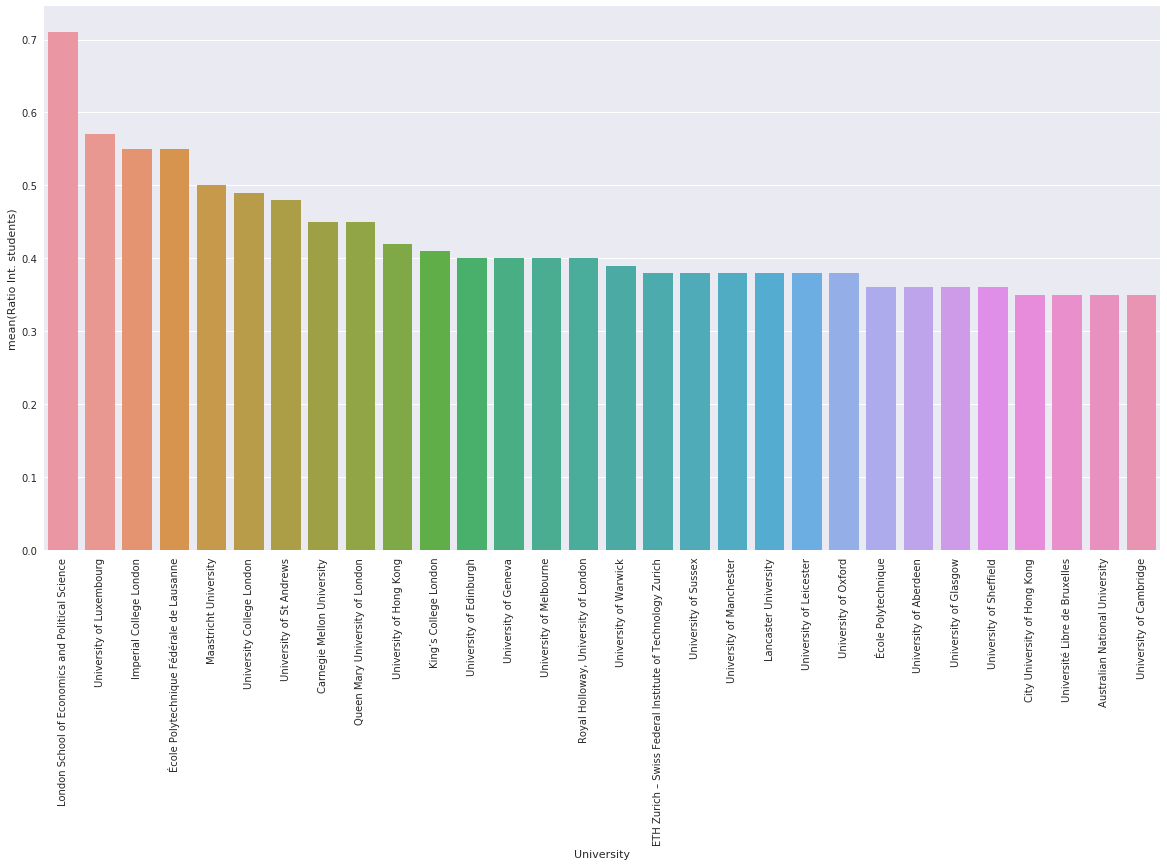

In [29]:
uni_ratio_int_stu(df2)

## Per country ratio

### Ratio between faculty members and students

Let's find the best country according to 1) ratio between faculty members and students and 2) ratio between local and international students. Previous assumptions about what is the best ratio still hold.

In [30]:
df2_country = df2.groupby(['Country']).agg(sum)

Best country according to ratio between faculty members and students is : Denmark


/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


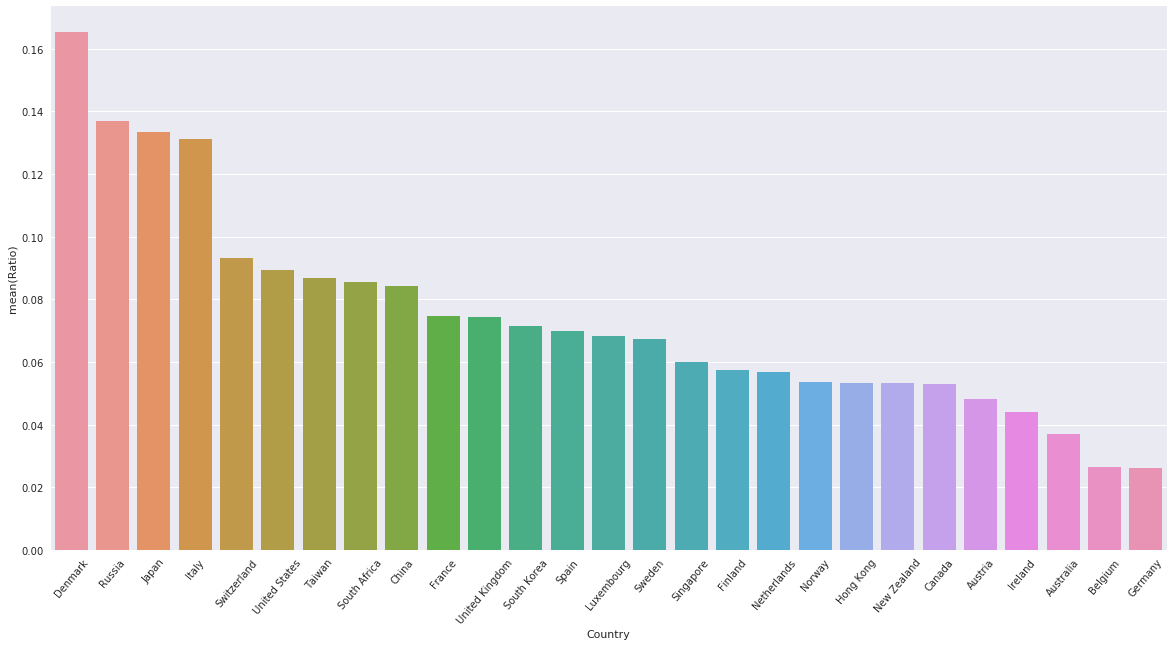

In [31]:
country_ratio_fac_stu(df2_country)

### Ratio between local and international students

Best country according to ratio between local and international students is : Luxembourg


/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


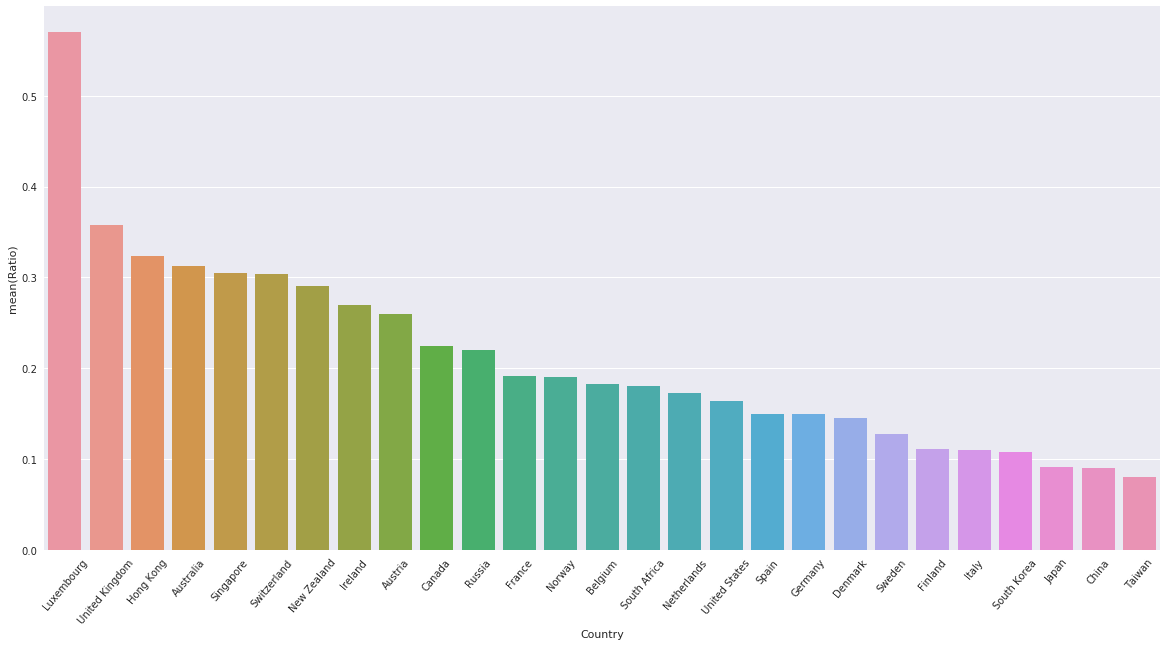

In [32]:
country_ratio_int_stu(df2_country)

Let's find the best region according to 1) ratio between faculty members and students and 2) ratio between local and international students. Previous assumptions about what is the best ratio still hold.

## Per region ratio

### Ratio between faculty members and students

In [33]:
df2_region = df2.groupby(['Region']).agg(sum)

Best region according to ratio between faculty members and students is : Africa


/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


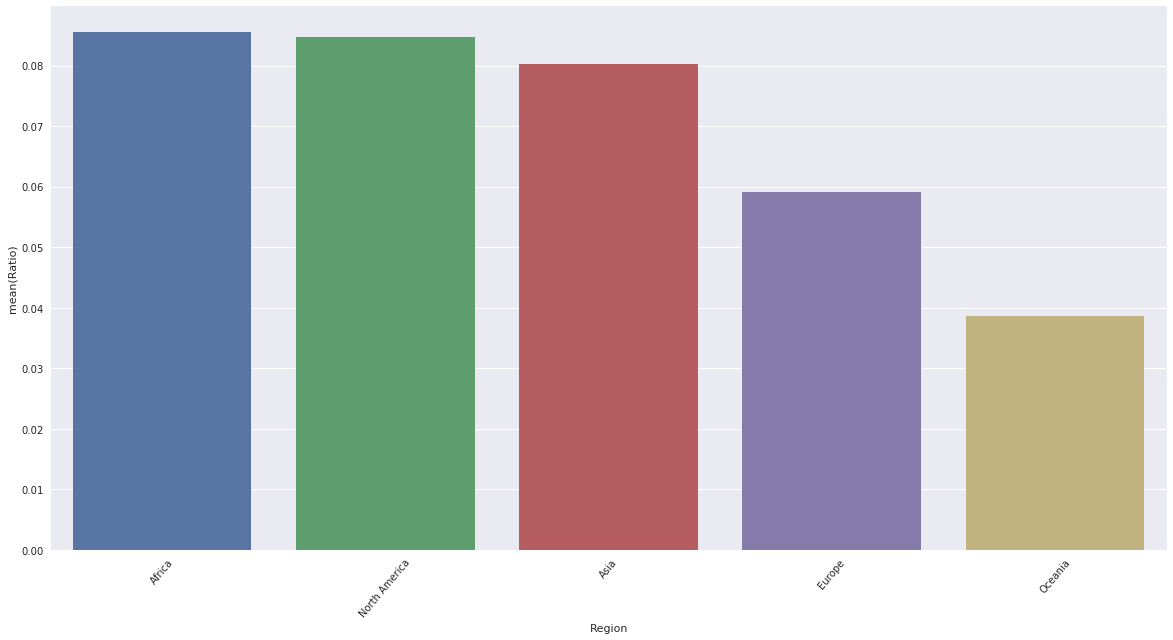

In [34]:
region_ratio_fac_stu(df2_region)

### Ratio between local and international students

Best region according to ratio between local and international students is : Oceania


/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


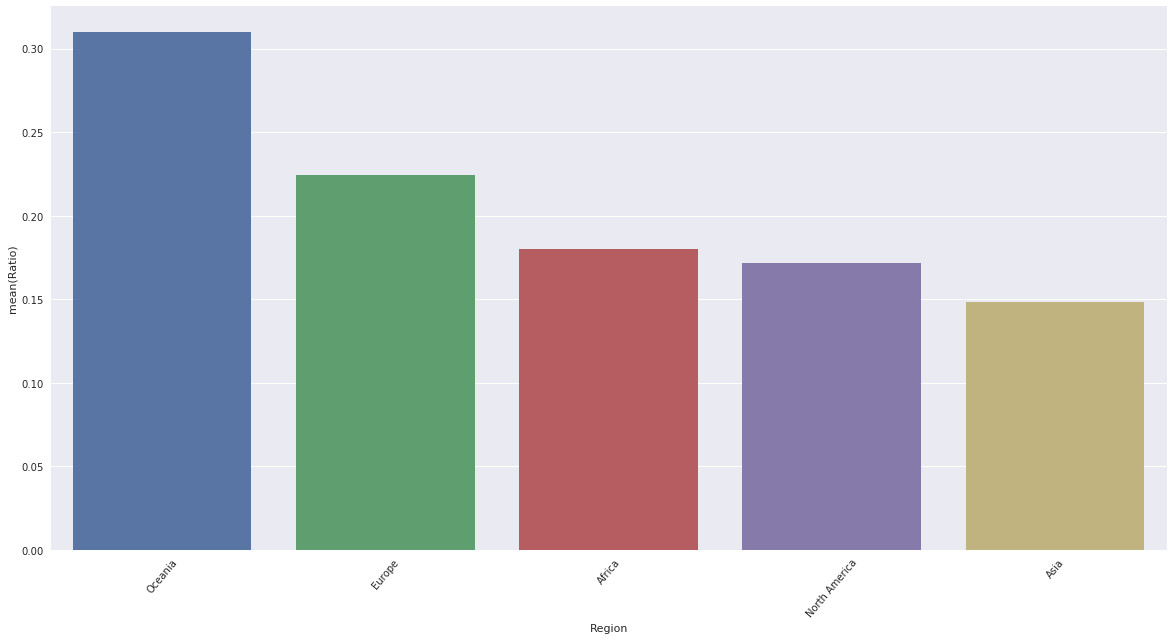

In [35]:
region_ratio_int_stu(df2_region)

# Observations on both ranking

- Oceania has the biggest ratio between local and internaionl students in both ranking

# Combining the two websites

To combine the two rankings, we will be using the name of the universities. However, the names are rarely exactly the same in both rankings, which means that we need to use regex to keep the important part of the name only. <br>
Sometimes regex will not be enough, and we will need to change the name in one of the dataframe manually.<br>

We start by working on the cases where regex is not enough.

In [36]:
df2.rename({'ETH Zurich – Swiss Federal Institute of Technology Zurich' : 'ETH Zurich – Swiss Federal Institute of Technology',
           'Wageningen University & Research' : 'Wageningen University'}, inplace=True)
df1.rename({'UCL (University College London)': 'University College London',
           'KAIST - Korea Advanced Institute of Science & Technology' : 'Korea Advanced Institute of Science and Technology (KAIST)',
           'Ludwig-Maximilians-Universität München' : 'LMU Munich',
           'Ruprecht-Karls-Universität Heidelberg' : 'Heidelberg University',
           'University of North Carolina, Chapel Hill' : 'University of North Carolina at Chapel Hill',
           'Trinity College Dublin, The University of Dublin' : 'Trinity College Dublin',
           'KIT, Karlsruhe Institute of Technology' : 'Karlsruhe Institute of Technology',
           'Humboldt-Universität zu Berlin' : 'Humboldt University of Berlin',
           'Freie Universitaet Berlin': 'Free University of Berlin',
           'Université de Montréal' : 'University of Montreal',
           'Université Pierre et Marie Curie (UPMC)' : 'Pierre and Marie Curie University',
           'Technische Universität Berlin (TU Berlin)' : 'Technical University of Berlin',
           'Universitat Autònoma de Barcelona' : 'Autonomous University of Barcelona',
           'Eberhard Karls Universität Tübingen' : 'University of Tübingen',
           'Albert-Ludwigs-Universitaet Freiburg' : 'University of Freiburg',
           'Scuola Superiore Sant\'Anna Pisa di Studi Universitari e di Perfezionamento': 'Scuola Superiore Sant’Anna'}, inplace=True)

And then we use regex on every university name.

In [37]:
regex1 = r'\([^()]*\)'
regex2 = r"(the)|(university)|(of)|(de)|(-)|( )|(’)|(')|\."
p = re.compile('('+regex1+'|'+regex2+')')

for df in [df1, df2]:
    df['University_regex'] = df.index.values
    # We first take care of the case
    df['University_regex'] = df['University_regex'].apply(lambda x: x.casefold())
    # Then we remove useless words, spaces, parentheses, their content and so on
    df['University_regex'] = df['University_regex'].apply(lambda x: str(re.sub(p, '', x)))
    # We then normalize the text to remove accents
    df['University_regex'] = df['University_regex'].apply(lambda x: unicodedata.normalize("NFKD", x))
    # And swith the encoding to utf-8
    df['University_regex'] = df['University_regex'].apply(lambda x: x.rstrip().encode('ascii', errors='ignore')
                                                                     .decode('utf-8'))


Once we know that the data is ready to be merged, we apply an inner merge. We chose to use an inner merge instead of an outer merge because it makes more sense to only keep universities present in both rankings.

In [38]:
df_merged = df2.reset_index().merge(df1, how='inner', on='University_regex').set_index('University')

Once the merge is done, we select and clean the data we are interested in. Moreover, since the number of student is different depending on the ranking, we decided to keep the average.

In [39]:
#Rename columns and put them in a new dataframe
df_all = df_merged.copy()
df_all['# Students (topuni)'] = df_merged['# Students_x']
df_all['# Students (times)'] = df_merged['# Students_y']
df_all['# Int. students (topuni)'] = df_merged['# Int. students_x']
df_all['# Int. students (times)'] = df_merged['# Int. students_y']
df_all['# Faculty members (topuni)'] = df_merged['# Faculty members_x']
df_all['# Faculty members (times)'] = df_merged['# Faculty members_y']
df_all['Rank topuni'] = df_merged['Rank_x']
df_all['Rank times'] = df_merged['Rank_y']
df_all['Country'] = df_merged['Country_x']
df_all['Region'] = df_merged['Region_x']
df_all['Ratio Int. students (topuni)'] = df_merged['Ratio Int. students_x']
df_all['Ratio Int. students (times)'] = df_merged['Ratio Int. students_y']
df_all['Ratio Faculty members (topuni)'] = df_merged['Ratio Faculty members_x']
df_all['Ratio Faculty members (times)'] = df_merged['Ratio Faculty members_y']

#Columns to keep
df_all = df_all[['# Students (topuni)', '# Students (times)',
                 '# Int. students (topuni)', '# Int. students (times)', '# Faculty members (topuni)',
                 '# Faculty members (times)', 'Rank topuni', 'Rank times', 'Country', 'Region',
                 'Ratio Int. students (topuni)', 'Ratio Int. students (times)', 'Ratio Faculty members (topuni)', 'Ratio Faculty members (times)']]
del df_merged

Plot of the correlation

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


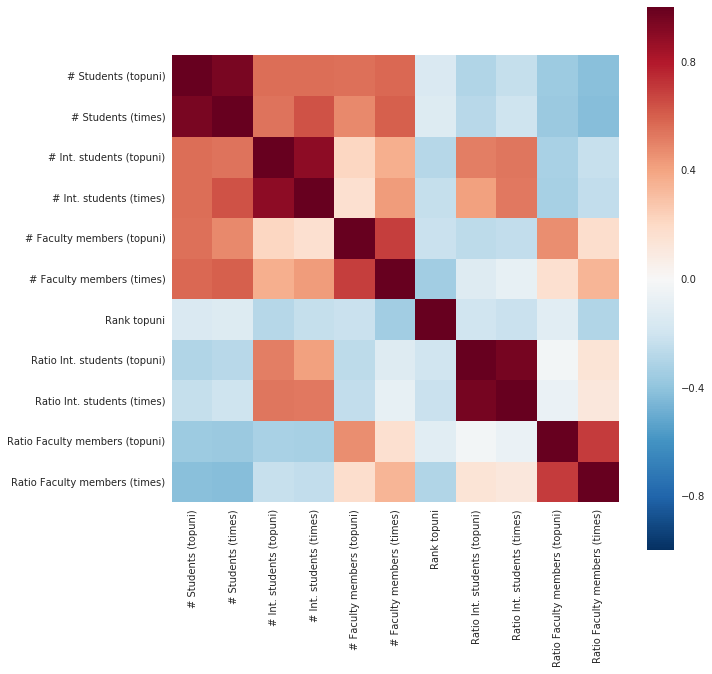

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_all.corr(), ax=ax, square=True)

Above, a few things are interesting to notice:
- When comparing the same corresponding data for each website, we can clearly distinguish a strong correlation which is something we can expect.
- There is a higher correlation between the ranking of TopUniversity and the number of students than for times higher education

## Best university
### Basic method

To find the best university according to both ranking, we could use the following method: We take the mean of both ranking and the university with the smallest mean is the best university. With this method we try to find the university closest to the top in both rankings.

In [60]:
df_all['Rank times'].head #There is equals in the rank, remove them DIRECTLY IN DF2 AND NOT ONLY in df_all
#REMOVE this line as well

University
University of Oxford                                     6
University of Cambridge                                  5
California Institute of Technology                       4
Stanford University                                      2
Massachusetts Institute of Technology                    1
Harvard University                                       3
Princeton University                                    13
Imperial College London                                  8
University of Chicago                                    9
ETH Zurich – Swiss Federal Institute of Technology      10
University of Pennsylvania                              19
Yale University                                         16
Johns Hopkins University                                17
Columbia University                                     18
University of California, Los Angeles                   33
University College London                                7
Duke University                              

In [59]:
df_all['Rank mean'] = (df_all['Rank times'] + df_all['Rank topuni'])/2.0
best = df_all.sort_values(by=['Rank mean'], ascending=True).iloc[0]

print("The best university according to both ranking is " + best.name + " with a mean rank score of {}".format(best["Rank mean"]))

del df_all['Rank mean']

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U21') dtype('<U21') dtype('<U21')

### Alternative method
What we could do, is extract the principal components of the data (A PCA, basically) and project the points on the main component.

In [61]:
pca = PCA(n_components=2)
ranks = [df_all[['Rank times']].values.flatten(), df_all[['Rank topuni']].values.flatten()]
ranks_new_basis = pca.fit(np.array(ranks).T).transform(np.array(ranks).T)
pca_score = pca.explained_variance_ratio_
V = pca.components_
ranks_pca_axis_x, ranks_pca_axis_y = V.T * pca_score / pca_score.min()

ValueError: could not convert string to float: '=76'

We then plotted the different Universities according to their respective ranking and showed the first two main component of the data (green and red).

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.title('Universities ranking')
plt.plot(df_all[['Rank times']].values.flatten(), df_all[['Rank topuni']].values.flatten(), '.')
plt.plot([100, 100 + ranks_pca_axis_x[0]*20], [100, 100 + ranks_pca_axis_y[0]*20], label='Main component')
plt.plot([100, 100 + ranks_pca_axis_x[1]*20], [100, 100 + ranks_pca_axis_y[1]*20], label='Second component')
plt.xlabel('Ranking according to Times')
plt.ylabel('Ranking according to Topuni')
plt.legend()
plt.show()

Once we have the principle component, we can use transform our data and change its basis from (rank times, rank topuni) to (main component, second component)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.scatter(ranks_new_basis.T[0], ranks_new_basis.T[1])
plt.plot([-125, 150], [0, 0], c='g', label='Main component')
plt.plot([140, 150], [4, 0], c='g')
plt.plot([140, 150], [-4, 0], c='g')
plt.xlabel('Main component')
plt.ylabel('Second component')
plt.title('Universities ranking in new basis')
plt.legend()
plt.show()

To get a final ranking system, we simply project the points on the main component axis and rate them depending on how far left they are. The more on the left, the better the rank.

In [ ]:
ranks_pca1 = ranks_new_basis.T[0]
temp = ranks_pca1.argsort()
new_ranks = np.empty(len(ranks_pca1), int)
new_ranks[temp] = np.arange(len(ranks_pca1))

We now add this new rank in the DataFrame and show the 20 first universities in our new ranking system.

In [ ]:
df_all['Rank total'] = new_ranks + 1

In [ ]:
df_all.sort_values(by='Rank total').head(20)